## Imports

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as stats
import pylab as pl
import random
from IPython.display import display
from scipy.fft import rfft, rfftfreq
from classifier import RoadQualityClassifier

## Load data

In [2]:
data_path = Path("../data/dataset_002/acceleration")
data = {
    "good": pd.read_csv(data_path/"good.csv"),
    "medium": pd.read_csv(data_path/"medium.csv"),
    "bad": pd.read_csv(data_path/"bad.csv")
}

## Transform to bicycle coordinates if needed

In [ ]:
def box_to_bicycle(vector):
    """Apply -145° x axis rotation and 90° z axis rotation"""
    return np.round((np.array([[ 6.12323400e-17,  8.19152044e-01, -5.73576436e-01],
                            [ 1.00000000e+00, -5.01585965e-17,  3.51214273e-17],
                            [ 0.00000000e+00, -5.73576436e-01, -8.19152044e-01]]) @ vector), decimals=12)

def cam_to_bicycle(vector):
    """Apply 43° x axis rotation and -90° z axis rotation"""
    return np.round((np.array([[ 6.12323400e-17,  7.31353702e-01, -6.81998360e-01],
                            [-1.00000000e+00,  4.47824985e-17, -4.17603554e-17],
                            [ 0.00000000e+00,  6.81998360e-01,  7.31353702e-01]]) @ vector), decimals=12)


for quality in data:
    data[quality] = pd.DataFrame([(row[1], *box_to_bicycle(np.c_[list(row[2:5])]).flat, *cam_to_bicycle(np.c_[list(row[5:8])]).flat) for row in data[quality].itertuples()], columns=["time", "x_box", "y_box", "z_box", "x_cam", "y_cam", "z_cam"])

data["good"]

## Get distribution of calculated indicator for every quality

In [3]:
def get_random_sample(data, interval_s, blacklist=[]):
    """get a random continous interval with given length from data"""
    interval_length = 0
    random_i = -1

    while interval_length < (interval_s - 0.05) or random_i in blacklist:
        random_i = random.randint(0, data.shape[0]-1)
        random_i_time = data.iloc[random_i]["time"]
        interval = data[((random_i_time - data["time"]) <= interval_s) & ((random_i_time >= data["time"]))]
        interval_length = interval.iloc[-1]["time"] - interval.iloc[0]["time"]
    
    return random_i, interval

def remove_std(values, n_std):
    values = np.array(values)
    mean = values.mean()
    std = values.std()

    condition = ((values >= mean-n_std*std) & (values <= mean+n_std*std))
    new_values = values[condition]
    return new_values

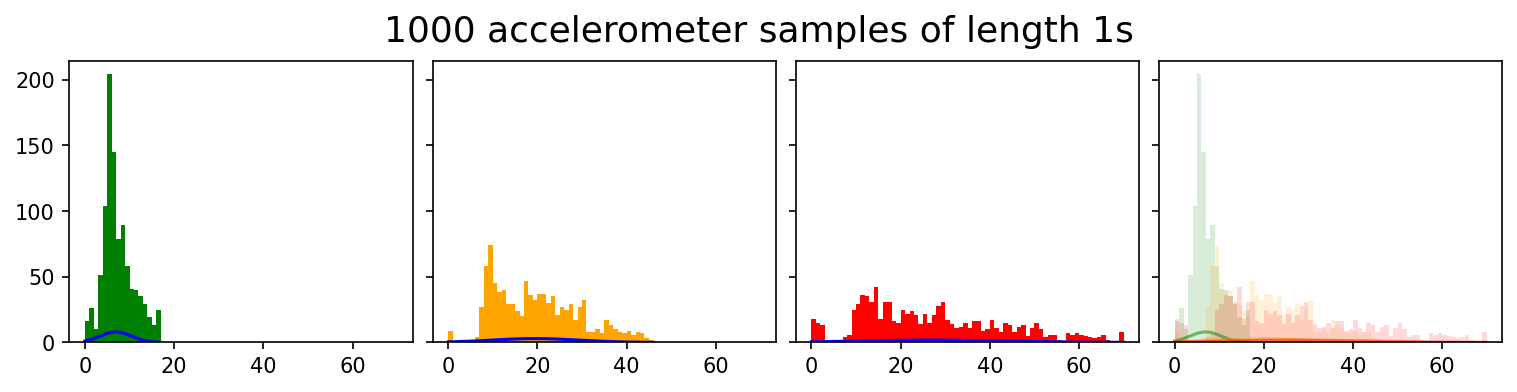

In [15]:
n_samples = 1000
interval_s = 1
classifier = RoadQualityClassifier()
max_value = 0
vals = []
norms = []

fig, axes = plt.subplots(1, 4, figsize=(10, 2.5), dpi=150, constrained_layout=True, sharex=True, sharey=True)
fig.suptitle("{} accelerometer samples of length {}s".format(n_samples, interval_s), fontsize="xx-large")
fig.patch.set_facecolor("white")
colors = ["green", "orange", "red"]

for k, quality in enumerate(data):

    quality_data = data[quality]
    used_i = []
    indicators = []

    for i in range(n_samples):

        sample_i, sample = get_random_sample(quality_data, interval_s, used_i)
        used_i.append(sample_i)
        ffts = classifier.get_fft(sample, range=[1,20])
        _stats = classifier.get_stats(ffts)
        indicators.append(classifier.get_indicator(_stats, accelerometers=[1,1], axes=[1,1], mean_max=[1,0]))
    
    if True:
        values = remove_std(sorted(indicators), 2)
    else:
        values = sorted(indicators)
    max_value = max(max_value, max(values))

    vals.append(values)
    norms.append(stats.norm.pdf(values, np.mean(values), np.std(values)))

    #axes[k].set_xlim((5, 30))
    axes[k].hist(values, int(max(values)-min(values)), color=colors[k])
    axes[3].hist(values, int(max(values)-min(values)), color=colors[k], alpha=0.15)

for j in range(3):
    axes[j].plot(vals[j], norms[j]*max_value, color="blue")
    axes[3].plot(vals[j], norms[j]*max_value, color=colors[j], alpha=0.5)


## Plot mean FFT of every quality and axis

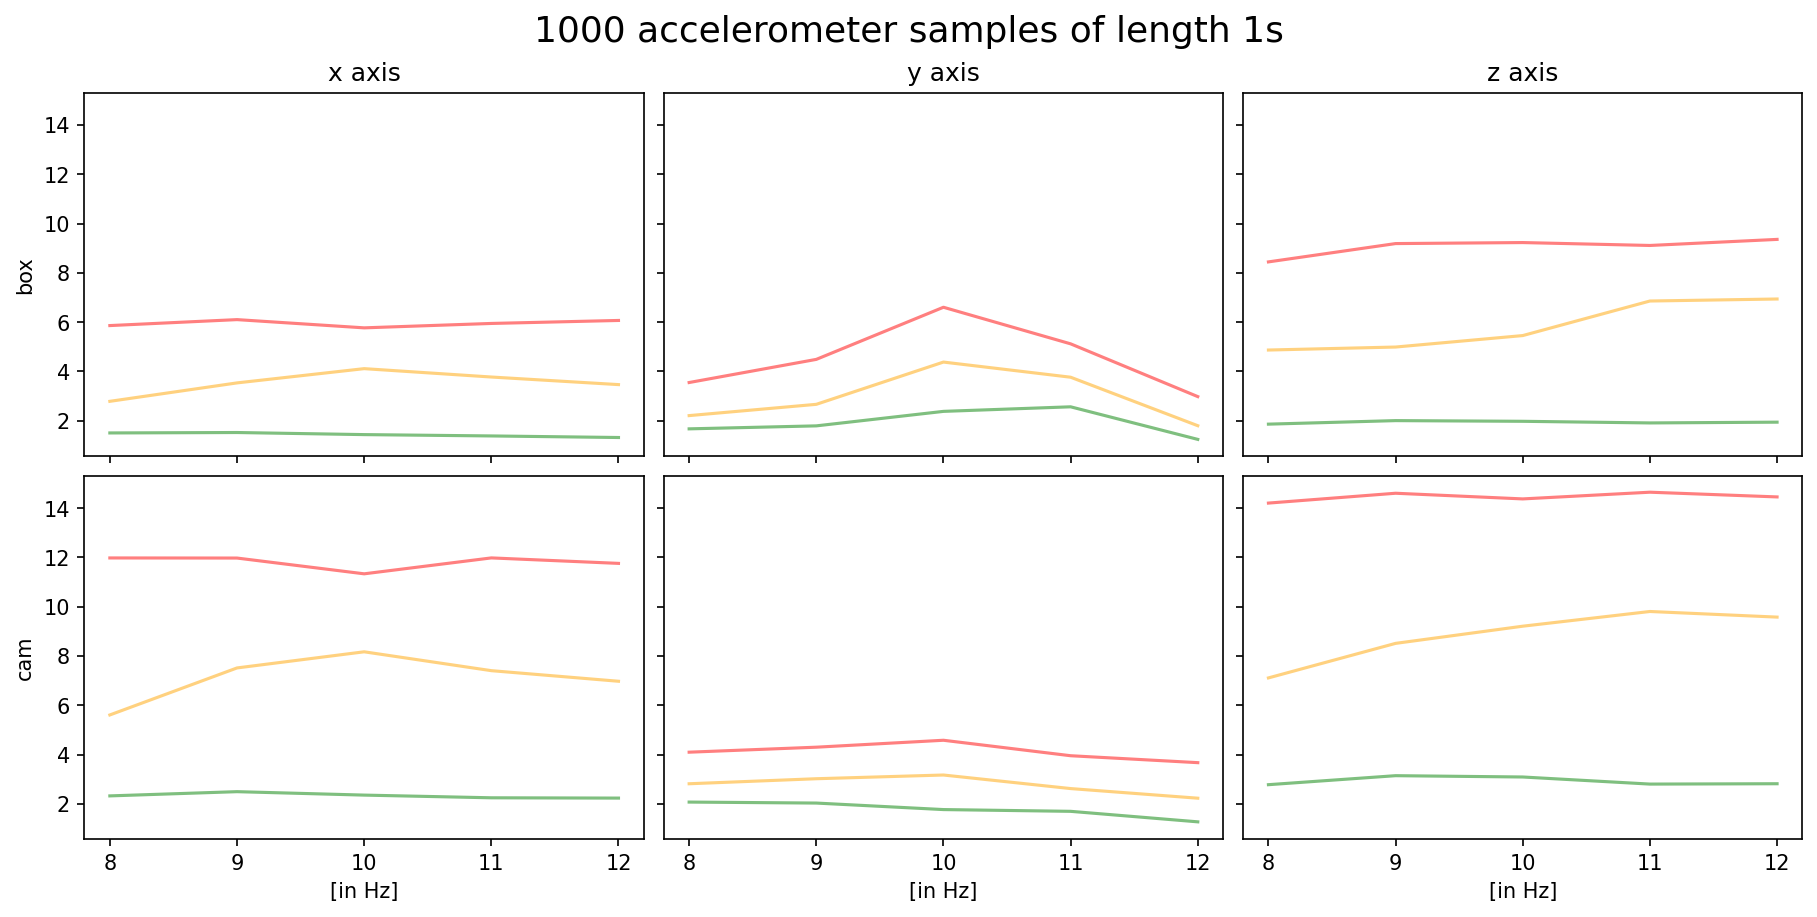

In [13]:
ac = ["box", "cam"]
ax = ["x", "y", "z"]
interval_s = 1
n_samples = 1000
f_range = [8, 12]
classifier = RoadQualityClassifier()

fig, axes = plt.subplots(2, len(ax), figsize=(4*len(ax), 6), dpi=150, constrained_layout=True, sharex=True, sharey=True)
fig.suptitle("{} accelerometer samples of length {}s".format(n_samples, interval_s), fontsize="xx-large")
colors = ["green", "orange", "red"]

for k, quality in enumerate(data):

    quality_data = data[quality]
    used_i = []
    ffts = []

    for i in range(n_samples):

        sample_i, sample = get_random_sample(quality_data, interval_s, used_i)
        used_i.append(sample_i)

        fft = classifier.get_fft(sample, axes=ax, range=f_range)
        ffts.append(fft)

    x = [*range(f_range[0], f_range[1]+1)]
    y = np.array(ffts, dtype=float).mean(axis=0)

    for _y, _ac in enumerate(y):
        for _x, _ax in enumerate(_ac):
            if _x == 0:
                axes[_y][_x].set_ylabel(ac[_y])
            if _y == 0:
                axes[_y][_x].set_title(ax[_x]+" axis")
            if _y == 1:
                axes[_y][_x].set_xlabel("[in Hz]")
            axes[_y][_x].plot(x, _ax, color=colors[k], alpha=0.5)
    

## deprecated

In [ ]:
ax = ["x", "y", "z"]
interval_s = 1
n_samples = 200
f_low = 1
f_high = 20

results = []

for accelerometer in ["box", "cam"]:

    means = np.zeros((3, 3))

    fig, axes = plt.subplots(len(ax), 3, figsize=(7.5, 2.5*len(ax)), dpi=150, constrained_layout=True, sharex=True, sharey=True)
    fig.suptitle("{} {} accelerometer samples of length {}s".format(n_samples, accelerometer, interval_s), fontsize="xx-large")
    colors = ["green", "orange", "red"]

    for j, axis in enumerate(ax):
        for k, quality in enumerate(data.keys()):
            sample_data = data[quality]
            
            used_i = []
            sample_rates = []
            ffts = []

            # n random intervals
            for n in range(n_samples):
                sample_i, sample = get_random_sample(data[quality], interval_s, used_i)
                used_i.append(sample_i)

                values = sample[axis+"_"+accelerometer].to_numpy()
                length = values.shape[0]

                # perform fft and get bins
                xf = rfftfreq(length, interval_s/length)
                yf = np.abs(rfft(values))

                # crop fft values from f_low to f_high
                ffts.append(yf[f_low:f_high+1])

            if len(ax) == 1:
                fig_ax = axes[k]
            else:
                fig_ax = axes[j][k]

            fig_ax.set_xlim((f_low, f_high))
            fig_ax.set_ylim((0, 25))
            if k == 0:
                fig_ax.set_ylabel(axis+" axis")
            if j == 0:
                fig_ax.set_title("{}".format(quality))
            if j == 2:
                fig_ax.set_xlabel("[in Hz]")

            xf = np.arange(f_low, f_high+1)
            yf = np.mean(np.array(ffts), axis=0)
            means[j][k] = yf.mean()
            fig_ax.plot(xf, yf, color=colors[k])

    results.append(np.array([2, 1, 3]) @ means)

print(results)